# Part 1: Data Preprocessing
- Load and clean the data using pandas
- Convert ratings data into a user-item matrix
- Handle missing data by filling unrated item appropriately
- Group and aggregate purchase behaviors per user and category

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def load_data(file_path_user, file_path_product):
    """
    Load the user interaction data and product metadata, then return them as DataFrames.
    """
    user_data = pd.read_csv(file_path_user)
    product_data = pd.read_csv(file_path_product)
    return user_data, product_data

def split_data(user_data, test_size=0.2, random_state=42):
    """
    Split the user_data into train and test sets.
    """
    return train_test_split(user_data, test_size=test_size, random_state=random_state)

def build_user_item_matrix(train_data):
    """
    Build a user-item matrix from the train data, filling missing values with 0.
    Rows = UserID, Columns = ProductID, Values = Rating.
    """
    user_item = train_data.pivot_table(index='UserID', columns='ProductID', values='Rating')
    user_item_filled = user_item.fillna(0)
    return user_item_filled

def mean_center_matrix(user_item_filled):
    """
    Mean-center the user-item matrix by temporarily replacing zeros with NaNs,
    then subtract each user's mean rating, and refilling with zeros.
    """
    user_item_nan = user_item_filled.replace(0, np.nan)
    user_means = user_item_nan.mean(axis=1)  # average rating per user row
    user_item_centered = user_item_nan.sub(user_means, axis=0)
    user_item_centered_filled = user_item_centered.fillna(0)
    return user_item_centered_filled

def aggregate_by_category(user_data):
    """
    Aggregate user behavior by category.
    """
    user_category_agg = user_data.groupby(['UserID', 'Category']).agg({
        'Rating': ['count', 'mean']
    }).reset_index()
    user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']
    return user_category_agg

def explore_data(user_data, product_data):
    """
    Data Exploration of datasets
    """

    print("\n\rMissing values in user data:")
    print(user_data.isnull().sum())
    print("\n\rMissing values in product data:")
    print(product_data.isnull().sum())

    user_activity = user_data.groupby('UserID').size()
    print("\n\rUser activity statistics:")
    print(user_activity.describe())

    plt.figure(figsize=(10, 5))
    sns.histplot(user_activity, kde=True, bins=20)
    plt.title('Distribution of, User Activity (#Ratings per User)', fontsize=14)
    plt.xlabel('Number of Ratings')
    plt.ylabel('Count of Users')
    plt.savefig('user_activity_distrib.png', dpi=300, bbox_inches='tight')
    plt.close()

    product_popularity = user_data.groupby('ProductID').size()
    print("\n\rProduct popularity statistics:")
    print(product_popularity.describe())

    plt.figure(figsize=(10, 5))
    sns.histplot(product_popularity, kde=True, bins=20)
    plt.title('Distribution of Product Popularity', fontsize=14)
    plt.xlabel('Number of Ratings')
    plt.ylabel('Count of Products')
    plt.savefig('product_popularity_distrib.png', dpi=300, bbox_inches='tight')
    plt.close()
    print("\n\rRating distribution:")
    rating_counts = user_data['Rating'].value_counts().sort_index()
    print(rating_counts)

    plt.figure(figsize=(10, 5))
    sns.countplot(x='Rating', data=user_data, palette='viridis')
    plt.title('Distribution of Ratings', fontsize=14)
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.savefig('rating_distrib.png', dpi=300, bbox_inches='tight')
    plt.close()

    category_counts = user_data['Category'].value_counts()
    print("\n\rCategory distribution:")
    print(category_counts)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Distribution of Interactions by Category', fontsize=14)
    plt.xlabel('Category')
    plt.ylabel('Number of Interactions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('category_distrib.png', dpi=300, bbox_inches='tight')
    plt.close()

    category_avg_ratings = user_data.groupby('Category')['Rating'].mean().sort_values(ascending=False)
    print("\n\rAverage ratings by category:")
    print(category_avg_ratings)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_avg_ratings.index, y=category_avg_ratings.values)
    plt.title('Average Rating by Category', fontsize=14)
    plt.xlabel('Category')
    plt.ylabel('Average Rating')
    plt.ylim(0, 5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('category_nonwavg_ratings.png', dpi=300, bbox_inches='tight')
    plt.close()



# Part 2: User-Based Collaborative Filtering
- Implement cosine similarity to measure user similarity
- Recommending top-N items based on the preferences of their most similar users
- Evaluating with Precision@K and Recall@K

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_user_similarity(centered_matrix):
    """
    Compute user-user cosine similarity on the mean-centered matrix
    (Adjusted cosine-similarity)
    Returns  DataFrame of similarities rating loc'ed/ix by userID
    """
    sim_matrix = cosine_similarity(centered_matrix)
    sim_df = pd.DataFrame(sim_matrix,
                          index=centered_matrix.index,
                          columns=centered_matrix.index)
    return sim_df

def recommend_top_n(target_user, user_item_matrix, similarity_df, n, k):
    """
    Recommend top-N items for a given user using user-based CF with mean-centered/adjusted cosine similarity.

    Parameters:
    target_user : str or int The user ID for whom we want recommendations.
    user_item_matrix : pd.DataFrame The user-item matrix (0 = not rated).
    similarity_df : pd.DataFrame User-user similarity matrix (mean-centered).
    n : int Number of items to recommend.
    k : int Number of neighbors to consider.

    Returns:
    pd.Series
        Top-N items with predicted ratings output
    """
    #Check user presence in matrix
    if target_user not in similarity_df.index:
        #Return empty if user does not exist in usually training data
        return pd.Series(dtype=float)

    # Similarity scores from df by user
    user_sims = similarity_df.loc[target_user].copy()

    # Each user Drop itself from similarity
    user_sims.drop(index=target_user, inplace=True, errors='ignore')

    #Top-K similar users loc'ed
    top_k_users = user_sims.nlargest(k).index

    #Items user hasn't rated yet (assuming 0 is N/A not rated)
    user_ratings = user_item_matrix.loc[target_user]
    unrated_items = user_ratings[user_ratings == 0].index
    if len(unrated_items) == 0:
        return pd.Series(dtype=float)

    # Ratings from neighbors of N/A items
    neighbor_ratings = user_item_matrix.loc[top_k_users, unrated_items]
    top_k_sims = user_sims[top_k_users]

    #Rating prediction heuristic: Weighted average rating predictions (weight using similarity)
    weighted_scores = neighbor_ratings.mul(top_k_sims, axis=0).sum(axis=0)
    normalization = top_k_sims.abs().sum() + 1e-9  # avoid division by zero
    predicted_ratings = weighted_scores / normalization

    return predicted_ratings.nlargest(n)

def precision_recall_at_k(user_id, train_matrix, test_data, similarity_df,
                          k_recs=10, top_k_users=10, relevant_threshold=4):
    """
    Calculate Precision@K and Recall@K for single user from TEST dataset usually
    relevant_threshold = minimum meaningful rating in the prior dataset
    """
    recs = recommend_top_n(user_id, train_matrix, similarity_df, n=k_recs, k=top_k_users)
    recommended_items = recs.index

    # Items the user rated >= relevant_threshold in test_data
    user_test_data = test_data[test_data['UserID'] == user_id]
    relevant_test_items = user_test_data[user_test_data['Rating'] >= relevant_threshold]['ProductID'].unique()

    hits = set(recommended_items).intersection(set(relevant_test_items))

    precision = len(hits) / k_recs if k_recs > 0 else 0
    recall = len(hits) / len(relevant_test_items) if len(relevant_test_items) > 0 else 0
    return precision, recall

def calculate_coverage(all_recommended_items, all_items):
    """
    Coverage = %items able be recommended / %items in catalog
    """
    unique_recommended = set(all_recommended_items)
    coverage = len(unique_recommended) / len(all_items) * 100
    return coverage

def run_grid_search(users_test, train_matrix, test_data, similarity_df):
    """
    Hyperparam optim using manual Grid-search over (k_recs, top_k_users, threshold) combos,
    computing average Precision@K and Recall@K.
    """
    k_recs_list = [5, 10, 15]
    top_k_users_list = [5, 10, 20]
    thresholds = [3, 4]

    results = []

    all_recommendations = []
    all_products = product_data['ProductID'].unique()

    for k_recs in k_recs_list:
        for k_users in top_k_users_list:
            for thresh in thresholds:
                precisions, recalls = [], []
                for user in users_test:
                    try:
                        p, r = precision_recall_at_k(
                            user, train_matrix, test_data, similarity_df,
                            k_recs=k_recs,
                            top_k_users=k_users,
                            relevant_threshold=thresh
                        )
                        precisions.append(p)
                        recalls.append(r)

                        topn_recs = recommend_top_n(user, train_matrix, similarity_df, n=k_recs, k=k_users)
                        all_recommendations.extend(topn_recs.index)
                    except KeyError:

                        continue

                avg_precision = np.mean(precisions) if precisions else 0
                avg_recall = np.mean(recalls) if recalls else 0
                coverage = calculate_coverage(all_recommendations, all_products)
                print(f"[k_recs={k_recs}, top_k={k_users}, threshold={thresh}] "
                      f"...-> Precision={avg_precision:.3f}, Recall={avg_recall:.3f},"
                      f"CatalogCoverage={coverage:.1f}%")

                results.append({
                    'k_recs': k_recs,
                    'top_k_users': k_users,
                    'threshold': thresh,
                    'avg_precision': avg_precision,
                    'avg_recall': avg_recall,
                    'coverage': coverage
                })
    return pd.DataFrame(results)

def get_detailed_recommendations_of_user(user_id, train_matrix, similarity_df, product_data, n=5, k=5):
    """
    Get detailed recommendations for a user with product information using trained thing.
    """
    recs = recommend_top_n(user_id, train_matrix, similarity_df, n=n, k=k)
    if recs.empty:
        return pd.DataFrame()

    recs_df = pd.DataFrame(recs).reset_index()
    recs_df.columns = ['ProductID', 'PredictedRating']

    detailed_recs = pd.merge(recs_df, product_data, on='ProductID')
    return detailed_recs

# Part 3: Association Rule Mining (Apriori)
- Convert user-product purchase data into transactions
- Implement the Apriori algorithm to find frequent itemsets
- Generate association rules and evaluate them based on:
 - Support
 - Confidence
 - Lift
- Visualize frequent itemsets using bar charts or network diagrams

In [12]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

def convert_to_transactions(user_data):
    """
    Convert user_data (UserID, ProductID) pairs to listxlist transactions) [Preprocess for apriori]
    """
    transactions = user_data.groupby('UserID')['ProductID'].apply(list).tolist()
    return transactions

def run_apriori(transactions, min_support=0.05):
    """
    Apply apriori algorithm to find frequent itemsets from a processed listxlist of transactions.
    """
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_trans = pd.DataFrame(te_ary, columns=te.columns_)

    frequent_itemsets = apriori(df_trans, min_support=min_support, use_colnames=True)
    return frequent_itemsets

def generate_association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5):
    """
    Given frequent itemsets from algorithm like Apriori, compute association rules by metric e.g. confidence.
    """
    rules_df = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)
    return rules_df

# Part 4: Visualization
- User similarity heatmaps
- Top-5 product recommendations for each user group

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_user_similarity_heatmap(similarity_df):
    """
    Visualize user-user similarity final ratigns using a Seaborn heatmap.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_df, cmap='YlGnBu')
    plt.title('User Similarity Heatmap')
    plt.show()

def plot_top_frequent_itemsets(frequent_itemsets, top_n=10):
    """
    Show top-N frequent itemsets by support using a simple labeled bar chart.
    """
    top_sets = frequent_itemsets.nlargest(top_n, 'support')
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(top_sets)), top_sets['support'], tick_label=top_sets['itemsets'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top Frequent Itemsets')
    plt.tight_layout()
    plt.show()

# Main Execution / Demo
Finally, let's tie it all together: load data, train/test split, build matrix, compute similarity, evaluate, run apriori.


Missing values in user data:
UserID       0
ProductID    0
Rating       0
Timestamp    0
Category     0
dtype: int64

Missing values in product data:
ProductID      0
ProductName    0
Category       0
dtype: int64

User activity statistics:
count    50.000000
mean     14.480000
std       3.271647
min      10.000000
25%      11.000000
50%      14.000000
75%      18.000000
max      20.000000
dtype: float64

Product popularity statistics:
count    100.000000
mean       7.240000
std        2.416776
min        2.000000
25%        6.000000
50%        7.000000
75%        9.000000
max       17.000000
dtype: float64

Rating distribution:
Rating
1    170
2    129
3    147
4    134
5    144
Name: count, dtype: int64


<ipython-input-10-8b4c8b16aa9d>:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=user_data, palette='viridis')



Category distribution:
Category
Electronics    172
Books          149
Toys           118
Clothing       115
Beauty         107
Home            63
Name: count, dtype: int64

Average ratings by category:
Category
Home           3.079365
Electronics    3.011628
Books          2.973154
Toys           2.932203
Beauty         2.822430
Clothing       2.800000
Name: Rating, dtype: float64
[k_recs=5, top_k=5, threshold=3] ...-> Precision=0.028, Recall=0.043,CatalogCoverage=76.0%
[k_recs=5, top_k=5, threshold=4] ...-> Precision=0.024, Recall=0.060,CatalogCoverage=76.0%
[k_recs=5, top_k=10, threshold=3] ...-> Precision=0.028, Recall=0.058,CatalogCoverage=79.0%
[k_recs=5, top_k=10, threshold=4] ...-> Precision=0.020, Recall=0.053,CatalogCoverage=79.0%
[k_recs=5, top_k=20, threshold=3] ...-> Precision=0.028, Recall=0.058,CatalogCoverage=79.0%
[k_recs=5, top_k=20, threshold=4] ...-> Precision=0.020, Recall=0.053,CatalogCoverage=79.0%
[k_recs=10, top_k=5, threshold=3] ...-> Precision=0.026, Recall=0

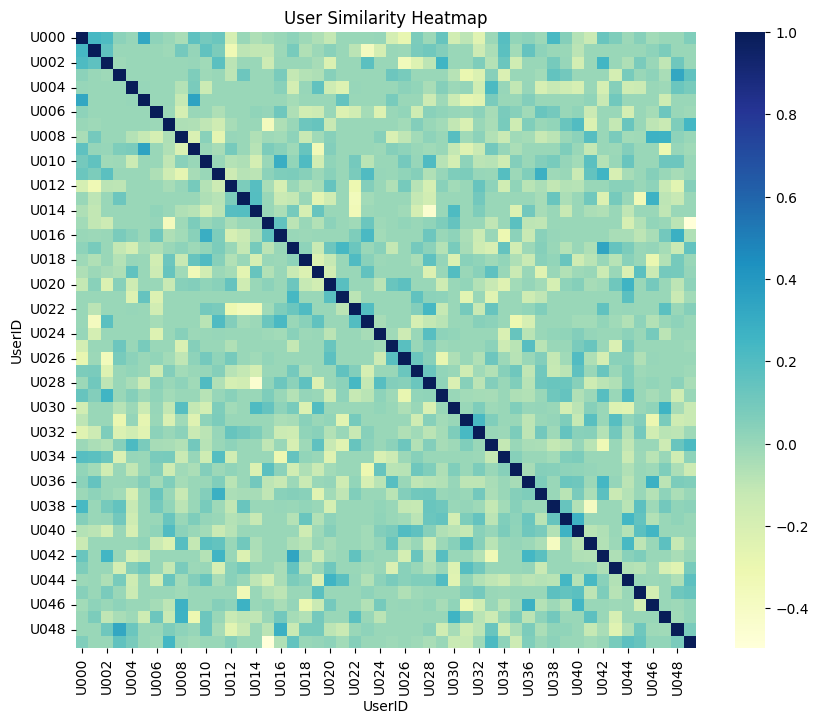

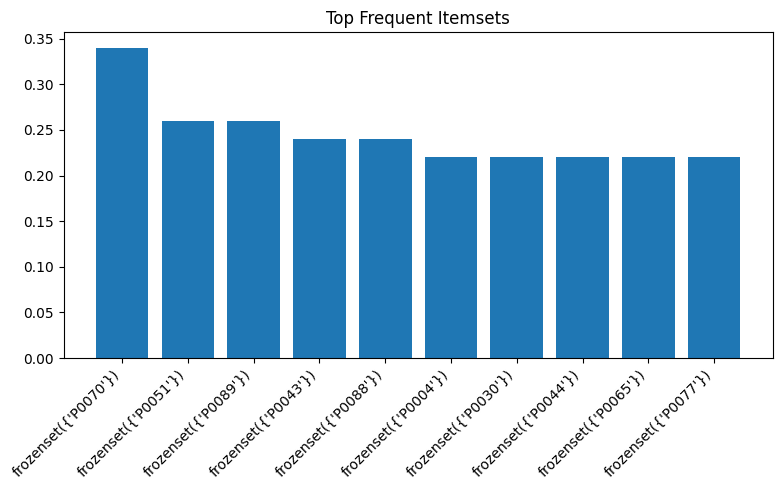


=== Recommendations for U001 ===
ProductID
P0005    2.651144
P0033    2.253493
P0070    1.981949
P0009    1.357718
P0048    1.357718
dtype: float64

Detailed Recommended Products:
   ProductID          ProductName Category  PredictedRating
5      P0005          Home Item 5     Toys         2.651144
33     P0033         Toys Item 33    Books         2.253493
70     P0070       Beauty Item 70     Toys         1.981949
9      P0009      Clothing Item 9    Books         1.357718
48     P0048  Electronics Item 48     Toys         1.357718


In [14]:
# [1] Load data
user_data, product_data = load_data(
    "ecommerce_user_data.csv",
    "product_details.csv"
)

# Aggregate user by category
user_category_agg = aggregate_by_category(user_data)

# Data exploration
explore_data(user_data, product_data)

# [2] Split data into train test datasets
train_data, test_data = split_data(user_data, test_size=0.2, random_state=42)

# [3] Build user-item matrix and adjusted/mean-center
train_matrix_filled = build_user_item_matrix(train_data)
train_matrix_centered = mean_center_matrix(train_matrix_filled)
similarity_df = compute_user_similarity(train_matrix_centered)

# Evaluate and Analyze Collaborative Filtering
users_test = test_data['UserID'].unique()
grid_results = run_grid_search(users_test, train_matrix_centered, test_data, similarity_df)

# Display best grid searched parma optim results by Precision
print("\n\r=== Top 5 Configs by Precision ===")
print(grid_results.sort_values(by='avg_precision', ascending=False).head(5))

# [4] Apriori
transactions = convert_to_transactions(user_data)
frequent_itemsets = run_apriori(transactions, min_support=0.05)
rules_df = generate_association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

print("\n\rSample Frequent Itemsets:")
print(frequent_itemsets.head())

print("\n\rAssociation Rules (sample):")
print(rules_df[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

# [5] Visualization
#Plot user similarity heatmap
plot_user_similarity_heatmap(similarity_df)

#Plot top frequent itemsets
plot_top_frequent_itemsets(frequent_itemsets, top_n=10)

# [extra] Example recommendation for a user
example_user = "U001"
recommended_series = recommend_top_n(
    target_user=example_user,
    user_item_matrix=train_matrix_filled,  # Use the filled matrix (but non-adjusted )
    similarity_df=similarity_df,
    n=5,
    k=5
)

print(f"\n\r=== Recommendations for {example_user} ===")
print(recommended_series)

# If you want product details:
recommended_df = product_data[product_data['ProductID'].isin(recommended_series.index)].copy()
recommended_df['PredictedRating'] = recommended_df['ProductID'].map(recommended_series)
recommended_df.sort_values(by='PredictedRating', ascending=False, inplace=True)

print("\n\rDetailed Recommended Products:")
print(recommended_df[['ProductID', 'ProductName', 'Category', 'PredictedRating']])

# More visualizations and analysis results

With the help of LLM and our original scripts,the excerpts below were generated, and then edited by hand afterwards to generate extra graphs, data, test, analysis and tables for our appendix and to deepen our analysis using all available tools

Sources: Microsoft Excel, Claude Sonnet 3.7, ChatGPT 3.5

In [ ]:
def visualize_frequent_itemsets(frequent_itemsets, product_data, top_n=10, save_path=None):
    """
    Visualize top-N frequent itemsets by support.
    """
    if frequent_itemsets.empty:
        print("No frequent itemsets found.")
        return

    # Get top N itemsets by support
    top_itemsets = frequent_itemsets.nlargest(top_n, 'support')

    # Create readable labels
    labels = []
    for itemset in top_itemsets['itemsets_list']:
        if len(itemset) == 1:
            product = product_data[product_data['ProductID'] == itemset[0]]
            if not product.empty:
                labels.append(f"{itemset[0]} ({product.iloc[0]['Category']})")
            else:
                labels.append(str(itemset[0]))
        else:
            labels.append(', '.join(itemset))

    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(labels)), top_itemsets['support'], align='center')
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Support')
    plt.title('Top Frequent Itemsets by Support', fontsize=14)

    # Add support values at the end of each bar
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{top_itemsets["support"].iloc[i]:.3f}',
                 va='center')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.savefig('output2/visualizations/frequent_itemsets.png', dpi=300, bbox_inches='tight')
    plt.close()

def visualize_association_rules(rules_df, product_data, top_n=10, save_path=None):
    """
    Visualize top-N association rules by lift using a scatter plot and matrix.
    Replaces networkx visualization with alternative matplotlib visualizations.
    """
    if rules_df.empty or len(rules_df) < top_n:
        print(f"Not enough rules to visualize. Only {len(rules_df)} rules found.")
        return

    # Get top N rules by lift
    top_rules = rules_df.nlargest(top_n, 'lift')

    # Create a matplotlib figure for scatter plot
    plt.figure(figsize=(10, 6))

    # Plot scatter of confidence vs support, with lift as size
    scatter = plt.scatter(
        top_rules['support'],
        top_rules['confidence'],
        s=top_rules['lift'] * 100,  # Scale size by lift
        alpha=0.6,
        c=top_rules['lift'],
        cmap='viridis'
    )

    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.title('Top Association Rules (Size and Color = Lift)', fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Lift')

    # Add annotations for selected top rules
    for i, rule in enumerate(top_rules.iloc[:5].iterrows()):
        rule = rule[1]
        ant = ', '.join([str(x) for x in rule['antecedents_list']])
        cons = ', '.join([str(x) for x in rule['consequents_list']])
        plt.annotate(
            f"{ant} → {cons}",
            (rule['support'], rule['confidence']),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )

    plt.tight_layout()
    plt.savefig('output2/visualizations/association_rules_scatter.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Also create a matrix visualization of product co-occurrence
    print("\nCreating product co-occurrence matrix visualization...")

    # Extract all unique products from rules
    all_products = set()
    for _, rule in top_rules.iterrows():
        all_products.update(rule['antecedents_list'])
        all_products.update(rule['consequents_list'])

    # Sort products for consistent ordering
    all_products = sorted(list(all_products))

    # Create empty co-occurrence matrix
    n_products = len(all_products)
    matrix = np.zeros((n_products, n_products))

    # Map product IDs to matrix indices
    product_to_idx = {prod: i for i, prod in enumerate(all_products)}

    # Fill matrix with lift values
    for _, rule in top_rules.iterrows():
        for ant in rule['antecedents_list']:
            for cons in rule['consequents_list']:
                ant_idx = product_to_idx[ant]
                cons_idx = product_to_idx[cons]
                matrix[ant_idx, cons_idx] = rule['lift']

    # Create readable product labels
    product_labels = []
    for prod in all_products:
        product_row = product_data[product_data['ProductID'] == prod]
        if not product_row.empty:
            label = f"{prod[:5]}.. ({product_row.iloc[0]['Category'][:3]})"
            product_labels.append(label)
        else:
            product_labels.append(str(prod))

    # Plot the matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        matrix,
        annot=True,
        cmap='YlGnBu',
        xticklabels=product_labels,
        yticklabels=product_labels,
        fmt='.1f'
    )
    plt.title('Product Association Lift Matrix (Top Rules)', fontsize=14)
    plt.tight_layout()
    plt.savefig('output2/visualizations/association_rules_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Also display the rules in tabular format
    print("Top Association Rules Details:")
    rule_details = []
    for _, rule in top_rules.iterrows():
        ant_names = get_product_names(rule['antecedents_list'], product_data)
        cons_names = get_product_names(rule['consequents_list'], product_data)
        rule_details.append({
            'Antecedents': ' & '.join(ant_names),
            'Consequents': ' & '.join(cons_names),
            'Support': rule['support'],
            'Confidence': rule['confidence'],
            'Lift': rule['lift']
        })
    print(pd.DataFrame(rule_details))

    return pd.DataFrame(rule_details)

def analyze_category_relationships(rules_df, product_data, save_path=None):
    """
    Analyze and visualize category relationships in association rules.
    """
    print("\n=== ANALYZING CATEGORY RELATIONSHIPS IN ASSOCIATION RULES ===")

    category_pairs = []
    for _, rule in rules_df.iterrows():
        for ant in rule['antecedents_list']:
            ant_cat = product_data[product_data['ProductID'] == ant]['Category'].values
            if len(ant_cat) > 0:
                ant_category = ant_cat[0]
                for cons in rule['consequents_list']:
                    cons_cat = product_data[product_data['ProductID'] == cons]['Category'].values
                    if len(cons_cat) > 0:
                        cons_category = cons_cat[0]
                        category_pairs.append({
                            'Antecedent Category': ant_category,
                            'Consequent Category': cons_category,
                            'Lift': rule['lift']
                        })

    if not category_pairs:
        print("No category pairs found in the rules.")
        return None

    category_pairs_df = pd.DataFrame(category_pairs)
    category_cross = category_pairs_df.groupby(['Antecedent Category', 'Consequent Category']).size().reset_index()
    category_cross.columns = ['Antecedent Category', 'Consequent Category', 'Count']
    category_cross['Avg Lift'] = category_pairs_df.groupby(['Antecedent Category', 'Consequent Category'])['Lift'].mean().values

    top_category_relationships = category_cross.sort_values('Avg Lift', ascending=False).head(10)
    print("Top Category Relationships:")
    print(top_category_relationships)

    # Visualize category relationships
    pivot_table = category_cross.pivot_table(
        values='Avg Lift',
        index='Antecedent Category',
        columns='Consequent Category',
        aggfunc='mean'
    ).fillna(0)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.2f')
    plt.title('Average Lift between Product Categories', fontsize=14)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.savefig('output2/visualizations/category_relationships.png', dpi=300, bbox_inches='tight')
    plt.close()

    return top_category_relationships

def generate_all_recommendations(user_item_matrix, similarity_df, product_data, n_recommendations=5, k_neighbors=10):
    """
    Generate recommendations for all users in the dataset.

    Parameters:
    -----------
    user_item_matrix : pd.DataFrame
        The user-item matrix with ratings
    similarity_df : pd.DataFrame
        The user similarity matrix
    product_data : pd.DataFrame
        The product metadata
    n_recommendations : int
        Number of products to recommend per user
    k_neighbors : int
        Number of neighbors to consider

    Returns:
    --------
    dict
        Dictionary mapping user IDs to their recommended products DataFrame
    """
    all_recommendations = {}

    for user_id in user_item_matrix.index:
        try:
            user_recs = get_detailed_recommendations_of_user(
                user_id,
                user_item_matrix,
                similarity_df,
                product_data,
                n=n_recommendations,
                k=k_neighbors
            )

            if not user_recs.empty:
                all_recommendations[user_id] = user_recs

        except Exception as e:
            print(f"Error generating recommendations for user {user_id}: {e}")

    return all_recommendations

def enhance_recommendations_with_rules(recommendations, rules_df, product_data):
    """
    Enhance user recommendations with association rules knowledge.

    For each user's recommendations, check if any association rules suggest additional
    products based on the already recommended items.
    """
    enhanced_recommendations = {}

    for user_id, user_recs in recommendations.items():
        # Get the recommended products
        rec_products = user_recs['ProductID'].tolist()

        # Find potential related products based on association rules
        related_products = set()
        for product in rec_products:
            # Check if this product is in any rule antecedents
            for _, rule in rules_df.iterrows():
                if product in rule['antecedents_list']:
                    # Add consequents to related products
                    related_products.update(rule['consequents_list'])

        # Remove products already in recommendations
        related_products = related_products - set(rec_products)

        # Create enhanced recommendations DataFrame
        enhanced_df = user_recs.copy()
        enhanced_df['Source'] = 'Collaborative Filtering'

        # Add associated products if any
        if related_products:
            related_df = product_data[product_data['ProductID'].isin(related_products)].copy()
            if not related_df.empty:
                # Only keep top 3 related products to avoid overwhelming the user
                related_df = related_df.head(3)
                related_df['PredictedRating'] = 3.0  # Default score for association-based recommendations
                related_df['Source'] = 'Association Rules'
                enhanced_df = pd.concat([enhanced_df, related_df[['ProductID', 'ProductName', 'Category', 'PredictedRating', 'Source']]])

        enhanced_recommendations[user_id] = enhanced_df

    return enhanced_recommendations

def analyze_recommendation_distribution(recommendations):
    """
    Analyze the distribution of recommended products and categories across users.
    """
    all_rec_products = []
    all_rec_categories = []

    for user_id, user_recs in recommendations.items():
        all_rec_products.extend(user_recs['ProductID'].tolist())
        all_rec_categories.extend(user_recs['Category'].tolist())

    # Product distribution
    product_counts = pd.Series(all_rec_products).value_counts()
    top_products = product_counts.head(10)

    # Category distribution
    category_counts = pd.Series(all_rec_categories).value_counts()

    return top_products, category_counts

def export_recommendations_to_csv(enhanced_recommendations, output_path='output2/smartcart_recommendations.csv'):
    """
    Export all recommendations to a CSV file.
    """
    # Prepare data for export
    all_recs_rows = []
    for user_id, user_recs in enhanced_recommendations.items():
        for _, row in user_recs.iterrows():
            all_recs_rows.append({
                'UserID': user_id,
                'ProductID': row['ProductID'],
                'ProductName': row['ProductName'],
                'Category': row['Category'],
                'PredictedRating': row['PredictedRating'],
                'Source': row['Source']
            })

    # Create DataFrame and export
    recommendations_df = pd.DataFrame(all_recs_rows)
    recommendations_df.to_csv(output_path, index=False)
    print(f"Recommendations saved to '{output_path}'")

    return recommendations_df


#############################################
# Part 5: Main Execution
#############################################

def main():
    """
    Main execution function.
    """
    print("SMARTCART: E-COMMERCE RECOMMENDER SYSTEM")
    print("=================================================")

    # 1. Load data
    print("\n📂 Loading data...")
    user_data, product_data = load_data(
        "ecommerce_user_data.csv",
        "product_details.csv"
    )

    print(f"User data shape: {user_data.shape}")
    print(f"Product data shape: {product_data.shape}")

    # 2. Explore data
    explore_data(user_data, product_data)

    # 3. Split data, build user-item matrix and calculate sparsity
    print("\nPreparing data...")
    train_data, test_data = split_data(user_data, test_size=0.2, random_state=42)
    print(f"Training set size: {train_data.shape}, Test set size: {test_data.shape}")

    # 4. Build user-item matrix
    train_matrix_filled = build_user_item_matrix(train_data)
    print(f"\nUser-item matrix shape: {train_matrix_filled.shape}")

    # 5. Calculate sparsity
    sparsity = (train_matrix_filled == 0).sum().sum() / (train_matrix_filled.shape[0] * train_matrix_filled.shape[1])
    print(f"\nMatrix sparsity: {sparsity:.2%}")

    # 6. Mean center the matrix for collaborative filtering
    train_matrix_centered = mean_center_matrix(train_matrix_filled)
    print("\nMean-centered matrix created")

    # 7. Visualize matrix sparsity
    plt.figure(figsize=(12, 8))
    binary_matrix = train_matrix_filled.notna().astype(int)
    sns.heatmap(train_matrix_filled.iloc[:20, :20] > 0, cmap='Blues', cbar=False)
    plt.title('User-Item Matrix Sparsity (First 20 Users, 20 Products)', fontsize=14)
    plt.xlabel('Products')
    plt.ylabel('Users')
    plt.tight_layout()
    plt.savefig('output2/visualizations/matrix_sparsity.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 8. Compute user similarity
    print("\n🔍 Computing user similarity matrix...")
    similarity_df = compute_user_similarity(train_matrix_centered)
    print("User similarity matrix shape:", similarity_df.shape)

    # 9. Visualize user similarity
    print("\nVisualizing user similarity matrix...")
    plt.figure(figsize=(12, 10))
    users_subset = similarity_df.index[:20]
    similarity_subset = similarity_df.loc[users_subset, users_subset]
    mask = np.triu(np.ones_like(similarity_subset))
    sns.heatmap(similarity_subset, cmap='YlGnBu', annot=False, mask=mask)
    plt.title('User Similarity Heatmap (First 20 Users)', fontsize=14)
    plt.tight_layout()
    plt.savefig('output2/visualizations/user_similarity_heatmap.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 10. Run grid search for collaborative filtering
    users_test = test_data['UserID'].unique()[:20]  # Using a subset for faster evaluation
    grid_results = run_grid_search(users_test, train_matrix_filled, test_data, similarity_df, product_data)

    # 11. Display best configurations
    print("\nTop 5 Configurations by Precision:")
    top_precision = grid_results.sort_values(by='avg_precision', ascending=False).head(5)
    print(top_precision)

    print("\nTop 5 Configurations by Recall:")
    top_recall = grid_results.sort_values(by='avg_recall', ascending=False).head(5)
    print(top_recall)

    # 12. Select best parameters
    best_config = grid_results.sort_values(by='avg_precision', ascending=False).iloc[0]
    best_k_recs = int(best_config['k_recs'])
    best_top_k = int(best_config['top_k_users'])
    print(f"\nUsing best parameters: k_recs={best_k_recs}, top_k={best_top_k}")

    # 13. Generate sample recommendations
    print("\n👤 Generating sample recommendations...")
    sample_user = "U001"
    detailed_recs = get_detailed_recommendations(sample_user, train_matrix_filled, similarity_df, product_data, n=best_k_recs, k=best_top_k)
    print(f"\nDetailed recommended products for user {sample_user}:")
    print(detailed_recs[['ProductID', 'ProductName', 'Category', 'PredictedRating']])

    # 14. Visualize sample recommendations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='ProductID', y='PredictedRating', data=detailed_recs, palette='viridis')
    plt.title(f'Recommendation Scores for User {sample_user}', fontsize=14)
    plt.xlabel('Product ID')
    plt.ylabel('Predicted Rating')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('output2/visualizations/sample_recommendations.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 15. Visualize category distribution in recommendations
    if not detailed_recs.empty:
        plt.figure(figsize=(10, 5))
        category_counts = detailed_recs['Category'].value_counts()
        sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
        plt.title(f'Category Distribution in Recommendations for User {sample_user}', fontsize=14)
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('output2/visualizations/recommendation_category_distribution.png', dpi=300, bbox_inches='tight')
        plt.close()

    # 16. Association rule mining
    print("\nConverting user-product interactions to transactions...")
    transactions = convert_to_transactions(user_data, min_rating=4)
    print(f"Number of transactions: {len(transactions)}")
    print(f"Sample transaction: {transactions[0][:5]} (truncated)")

    # 17. Find frequent itemsets
    print("\nFinding frequent itemsets using Apriori...")
    frequent_itemsets = run_apriori(transactions, min_support=0.03)
    print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")
    print("\nSample frequent itemsets:")
    print(frequent_itemsets[['itemsets_list', 'support']].head(10))

    # 18. Generate association rules
    print("\nGenerating association rules...")
    rules_df = generate_association_rules(frequent_itemsets, metric='confidence', min_threshold=0.3)
    print(f"Number of rules generated: {len(rules_df)}")
    print("\nSample association rules:")
    print(rules_df[['antecedents_list', 'consequents_list', 'support', 'confidence', 'lift']].head(10))

    # 19. Visualize frequent itemsets
    print("\nVisualizing frequent itemsets...")
    visualize_frequent_itemsets(frequent_itemsets, product_data, top_n=10)

    # 20. Visualize association rules (now using alternative to networkx)
    print("\nVisualizing association rules with alternative to networkx...")
    rule_details = visualize_association_rules(rules_df, product_data, top_n=15)

    # 21. Analyze category relationships
    top_category_relationships = analyze_category_relationships(rules_df, product_data)

    # 22. Generate recommendations for all users
    print("\nGenerating recommendations for all users...")
    all_recommendations = generate_all_recommendations(
        train_matrix_filled,
        similarity_df,
        product_data,
        n_recommendations=5,
        k_neighbors=10
    )
    print(f"Generated recommendations for {len(all_recommendations)} users")

    # 23. Enhance recommendations with association rules
    print("\nEnhancing recommendations with association rules...")
    enhanced_recommendations = enhance_recommendations_with_rules(all_recommendations, rules_df, product_data)

    # 24. Display sample enhanced recommendations
    sample_user = list(enhanced_recommendations.keys())[0]
    print(f"\nEnhanced recommendations for user {sample_user}:")
    print(enhanced_recommendations[sample_user][['ProductID', 'ProductName', 'Category', 'PredictedRating', 'Source']])

    # 25. Analyze recommendation distribution
    print("\nAnalyzing recommendation distribution...")
    top_products, category_counts = analyze_recommendation_distribution(enhanced_recommendations)

    print("\nTop recommended products:")
    print(top_products)

    print("\nRecommended categories distribution:")
    print(category_counts)

    # 26. Visualize category distribution
    plt.figure(figsize=(10, 6))
    category_counts.plot(kind='bar', color=sns.color_palette('viridis', len(category_counts)))
    plt.title('Distribution of Recommended Categories Across All Users', fontsize=14)
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('output2/visualizations/recommendation_distribution.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 27. Export recommendations to CSV
    print("\nExporting recommendations to CSV...")
    recommendations_df = export_recommendations_to_csv(enhanced_recommendations)
    print("\nSample of exported recommendations:")
    print(recommendations_df.head(10))

    # 28. Analyze data sparsity impact
    print("\n=== ANALYZING DATA SPARSITY IMPACT ===")

    # Analyze user activity distribution
    user_activity = user_data.groupby('UserID').size()
    users_by_activity = pd.qcut(user_activity, 3, labels=['Low', 'Medium', 'High'])
    user_groups = pd.DataFrame({'Activity': users_by_activity}).reset_index()

    # Analyze performance by user activity level
    performance_by_activity = []

    for activity_level in ['Low', 'Medium', 'High']:
        users_in_group = user_groups[user_groups['Activity'] == activity_level]['UserID'].tolist()
        users_in_test = [u for u in users_in_group if u in test_data['UserID'].unique()]

        if not users_in_test:
            continue

        precisions, recalls = [], []

        for user in users_in_test[:10]:  # Limit to 10 users per group for speed
            try:
                p, r = precision_recall_at_k(
                    user, train_matrix_filled, test_data, similarity_df,
                    k_recs=10, top_k_users=10, relevant_threshold=4
                )
                precisions.append(p)
                recalls.append(r)
            except Exception as e:
                continue

        if precisions and recalls:
            performance_by_activity.append({
                'Activity Level': activity_level,
                'Average Precision': np.mean(precisions),
                'Average Recall': np.mean(recalls),
                'Number of Users': len(users_in_group)
            })

    performance_df = pd.DataFrame(performance_by_activity)
    print("\nRecommendation performance by user activity level:")
    print(performance_df)

    # Visualize the relationship
    if not performance_df.empty:
        plt.figure(figsize=(10, 6))

        bar_width = 0.35
        index = np.arange(len(performance_df))

        plt.bar(index, performance_df['Average Precision'], bar_width, label='Precision')
        plt.bar(index + bar_width, performance_df['Average Recall'], bar_width, label='Recall')

        plt.xlabel('User Activity Level')
        plt.ylabel('Score')
        plt.title('Recommendation Performance by User Activity Level', fontsize=14)
        plt.xticks(index + bar_width/2, performance_df['Activity Level'])
        plt.legend()
        plt.tight_layout()
        plt.savefig('output2/visualizations/performance_by_activity.png', dpi=300, bbox_inches='tight')
        plt.close()

    print("\nSmartCart implementation completed successfully!")
    print("Check the 'output2/' directory for results and visualizations.")